In [9]:
using JuMP
import Ipopt
using StaticArrays, LinearAlgebra
using Plots
using Symbolics: Symbolics, @variables, scalarize
using Latexify
using BlockArrays: Block, BlockVector, mortar, blocksizes
using Ipopt
using SparseArrays
using CSV
using DataFrames
using Tables

In [10]:
function uni_dyna(x,u)
    return [x[1]+dt*u[1]*cos(x[3]), x[2]+dt*u[1]*sin(x[3]), x[3]+dt*u[2]]
end

function circleShape(h, k, r); gr()
    theta = LinRange(0, 2*pi, 500)
    h.+ r*sin.(theta), k.+ r*cos.(theta)
end

N = 100
n_x = 6
n_u = 4
state_dimension = 3
control_dimension = 2
horizon = N
tf = 10.
dt = tf/(N)
u1_b = 0.15
u2_b = 0.75

xo = @SVector [10.0,0.0]
ro = 4.0
ra = 3.0

# Q = 50.0*Diagonal(@SVector ones(6))
# Qf = 10000.0*Diagonal(@SVector ones(6))
# R = 1.0e0*Diagonal(@SVector ones(4))

Q = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*0.6 # This is reference tracking and control cost
Qf = Diagonal(@SVector [50, 10, 5, 50, 10, 5, 5, 5, 2, 2])*50
R = Diagonal(@SVector [10, 10, 5, 5])*0.8

noise_level = 0.5 

full_traj = []
full_traj2 = []

num_sim = 1000

for sim in 1:num_sim

    x0 = [0,0,0,20,0,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]
    xf = [20,0.0,0,0,0,pi] + [noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0, noise_level*(2*rand()-1), noise_level*(2*rand()-1), 0]

    # xf2 = @SVector [20,-2,0,0,-2,pi]

    X_ref = hcat(collect(LinRange(x0[1],xf[1],N+1)), 
            collect(LinRange(x0[2],xf[2],N+1)),
            collect(LinRange(x0[3],xf[3],N+1)),
            collect(LinRange(x0[4],xf[4],N+1)), 
            collect(LinRange(x0[5],xf[5],N+1)),
            collect(LinRange(x0[6],xf[6],N+1)), zeros(N+1),zeros(N+1), zeros(N+1),zeros(N+1))

    problem_size = N*(n_x+n_u)

    model = Model(Ipopt.Optimizer)

    @variable(model, x11[1:N+1])
    @variable(model, x12[1:N+1])
    @variable(model, x13[1:N+1])
    @variable(model, x21[1:N+1])
    @variable(model, x22[1:N+1])
    @variable(model, x23[1:N+1])

    @variable(model, 0<=u11[1:N+1] , start = 0)
    @variable(model, u12[1:N+1], start = 0);
    @variable(model, 0<=u21[1:N+1], start = 0)
    @variable(model, u22[1:N+1], start = 0);

    @variable(model, -u1_b <= du11[1:N+1] <= u1_b, start = 0)
    @variable(model, -u2_b <= du12[1:N+1] <= u2_b, start = 0);
    @variable(model, -u1_b <= du21[1:N+1] <= u1_b, start = 0)
    @variable(model, -u2_b <= du22[1:N+1] <= u2_b, start = 0);

    fix(x11[1],x0[1],force=true)
    fix(x12[1],x0[2],force=true)
    fix(x13[1],x0[3],force=true)
    fix(x21[1],x0[4],force=true)
    fix(x22[1],x0[5],force=true)
    fix(x23[1],x0[6],force=true)

    fix(u11[N+1],0.0,force=true)
    fix(u12[N+1],0.0,force=true)
    fix(u21[N+1],0.0,force=true)
    fix(u22[N+1],0.0,force=true)

    fix(du11[N+1],0.0,force=true)
    fix(du12[N+1],0.0,force=true)
    fix(du21[N+1],0.0,force=true)
    fix(du22[N+1],0.0,force=true)

    X_full = vcat(x11',x12',x13',x21',x22',x23',u11',u21',u12',u22')
    U_full = vcat(du11',du21',du12',du22')

    @objective(model, Min, tr((X_full'[1:N,:] - X_ref[1:N,:])*Q*(X_full[:,1:N] - X_ref'[:,1:N])) + tr(U_full'*R*U_full) + (X_full'[1+N,:] - X_ref[1+N,:])'*Qf*(X_full[:,1+N] - X_ref'[:,1+N]))

    @constraint(model, [t in 1:N], uni_dyna([x11[t],x12[t],x13[t]],[u11[t],u12[t]]) == [x11[t+1],x12[t+1],x13[t+1]]);
    @constraint(model, [t in 1:N], uni_dyna([x21[t],x22[t],x23[t]],[u21[t],u22[t]]) == [x21[t+1],x22[t+1],x23[t+1]]);
    @constraint(model, [t in 1:N], [u21[t]+du21[t+1],u22[t]+du22[t+1]] == [u21[t+1],u22[t+1]]);
    @constraint(model, [t in 1:N], [u11[t]+du11[t+1],u12[t]+du12[t+1]] == [u11[t+1],u12[t+1]]);
    @constraint(model, [t in 1:N+1], (x21[t] - x11[t])^2 + (x22[t] - x12[t])^2 - ra^2 >= 0);

    for i in 1:N+1
        set_start_value(x11[i],X_ref[i,1]+ 0.1*(2*rand()-1))
        set_start_value(x12[i],X_ref[i,2]+ 0.1*(2*rand()-1))
        set_start_value(x13[i],X_ref[i,3]+ 0.1*(2*rand()-1))
        set_start_value(x21[i],X_ref[i,4]+ 0.1*(2*rand()-1))
        set_start_value(x22[i],X_ref[i,5]+ 0.1*(2*rand()-1))
        set_start_value(x23[i],X_ref[i,6]+ 0.1*(2*rand()-1))

        set_start_value(u11[i],X_ref[i,7])
        set_start_value(u12[i],X_ref[i,8])
        set_start_value(u21[i],X_ref[i,9])
        set_start_value(u22[i],X_ref[i,10])

        set_start_value(du11[i],0.0)
        set_start_value(du12[i],0.0)
        set_start_value(du21[i],0.0)
        set_start_value(du22[i],0.0)
        
    end

    optimize!(model)

    @assert is_solved_and_feasible(model)

    X1 = hcat(value.(x11),value.(x12),value.(x13))
    X2 = hcat(value.(x21),value.(x22),value.(x23))

    traj = hcat(value.(u11),value.(u12),value.(u21),value.(u22),
                value.(x11),value.(x12),value.(x13), 
                value.(x21),value.(x22),value.(x23))

    traj2 = hcat(value.(x11),value.(x12), value.(x21),value.(x22))

    if sim == 1
        full_traj = traj[1:100,:]
        full_traj2 = traj2[1:100,:]
        Plots.plot(X1[:,1],X1[:,2],color="blue",label="Agent 1")
        Plots.plot!(X2[:,1],X2[:,2],color="orange",label="Agent 2")
    else
        full_traj = vcat(full_traj,traj[1:100,:])
        full_traj2 = vcat(full_traj2,traj2[1:100,:])
        Plots.plot!(X1[:,1],X1[:,2],color = "blue",label="")
        Plots.plot!(X2[:,1],X2[:,2],color="orange",label="")
    end
end

This is Ipopt version 3.14.16, running with linear solver MUMPS 5.7.3.

Number of nonzeros in equality constraint Jacobian...:     3382
Number of nonzeros in inequality constraint Jacobian.:      800
Number of nonzeros in Lagrangian Hessian.............:     3192

Total number of variables............................:     1400
                     variables with only lower bounds:      200
                variables with lower and upper bounds:      400
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1000
Total number of inequality constraints...............:      101
        inequality constraints with only lower bounds:      101
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  4.8786429e+01 8.93e+00 3.58e+00  -1.0 0.00e+00    -  0.00e+00 0.00e+00 

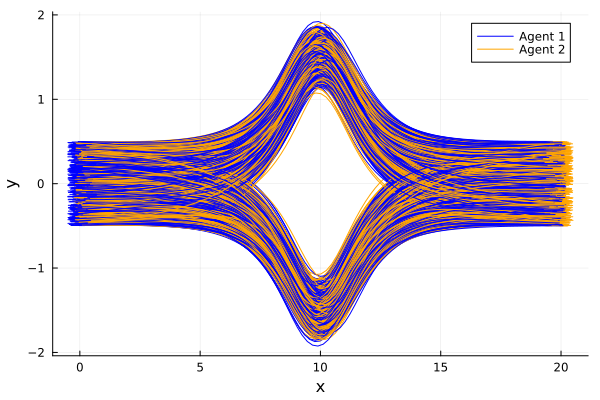

In [11]:
Plots.xlabel!("x")
Plots.ylabel!("y")

In [12]:
for i in 1:(size(full_traj)[2])
    println(maximum(full_traj[:,i]))
end

3.4500002267284184
1.5661523172413476
3.449999896288377
1.5727872084054362
20.222643444508854
1.9214503365520523
0.5761083442595596
20.499066088118973
1.8999011553888718
3.7106247805588097


In [13]:
CSV.write("data/full_traj_two.csv",  Tables.table(full_traj), writeheader=false)
CSV.write("data/full_traj_two_simple.csv",  Tables.table(full_traj2), writeheader=false)

"data/full_traj_two_simple.csv"

In [14]:
load_traj = Array(CSV.read("data/full_traj_two_simple.csv",DataFrame,header=false);)

100000×4 Matrix{Float64}:
  0.38051    0.195194  20.0434     -0.248235
  0.573162   0.195194  19.8381     -0.248235
  0.765816   0.194685  19.6328     -0.246924
  0.958471   0.193747  19.4274     -0.244502
  1.15113    0.192491  19.2221     -0.241232
  1.34378    0.191026  19.0167     -0.237374
  1.53644    0.189453  18.8114     -0.233151
  1.72909    0.187857  18.606      -0.228748
  1.92174    0.18631   18.4007     -0.224306
  2.1144     0.184871  18.1954     -0.219935
  ⋮                                
 19.3896    -0.46064    0.504963   -0.44725
 19.5096    -0.461983   0.384992   -0.449898
 19.6146    -0.463116   0.280015   -0.452103
 19.7046    -0.464036   0.190033   -0.453877
 19.7796    -0.464743   0.115045   -0.455228
 19.8396    -0.465241   0.0550525  -0.456175
 19.8846    -0.465548   0.0100562  -0.456756
 19.9146    -0.465699  -0.0199424  -0.457043
 19.9296    -0.465748  -0.0349421  -0.457135